### Roland Farrell 04/02/23
### This notebook efficiently constructs the Hamiltonian for QCD with two flavors of quarks (up and down) on a one dimensional lattice. Once constructed, exact methods are used to obtain the spectrum, the entanglement between quarks and antiquarks and perform time evolution. The mapping to qubits is given in arXiv:2207.01731  

In [1]:
using SparseArrays, Arpack, LinearAlgebra, Plots, Expokit, Folds

# Create the Hamiltonian as a sum of Pauli strings, for example $H=\sigma^+\otimes\sigma^z\otimes\sigma^- \otimes\cdots \ + \ \sigma^z\otimes\sigma^-\otimes\sigma^+\otimes\cdots \ + \ \ldots$ 
# This is kept in tensor product form as it is more efficient to store and manipulate.

## Operators are encoded as a tuple ( Dict{ UInt8 , UInt8 } , Float64 ). The dictionary has (key, value) = (qubit number, Pauli) and the Float64 is the coefficient of this term. The qubit number starts at zero and runs from right to left. For example $\lvert 000000111011\rangle$ represents a blue up quark since qubit 2 is $0$ (spin up).  The Paulis are encoded as $\sigma^+ \to 0$, $\sigma^- \to 1$, $\sigma^z \to 2$.

### Construct the mass part of the Hamiltonian, takes in $N=2L$ and outputs an array of operators.

In [2]:
function Hm(N)
    op = Array{Tuple{Dict{UInt8,UInt8}, Float64}}(undef, 0)
    # The identity is an empty dictionary
    push!(op,(Dict() , 3*N))
    # For each fermion, flavor and color
    for n in 0:N-1
        for f in 0:1
            for c in 0:2
                if f==0
                    push!(op,(Dict(6*n+3*f+c => 2), (0.5)*(-1)^(n)))
                else
                    push!(op,(Dict(6*n+3*f+c => 2), (0.5)*(-1)^(n)))
                end
            end
        end
    end
    op
end

Hm (generic function with 1 method)

### Construct the kinetic part of the Hamiltonian, takes in $N=2L$ and outputs an array of operators.

In [3]:
function Hkin(N)
    op = Array{Tuple{Dict{UInt8,UInt8}, Float64}}(undef, 0)
    for n in 0:N-2
        for f in 0:1
            for c in 0:2
                push!(op,(Dict(6*n+3*f+c => 0, 6*n+3*f+c+1 => 2, 6*n+3*f+c+2 => 2, 6*n+3*f+c+3 => 2, 6*n+3*f+c+4 => 2, 6*n+3*f+c+5 => 2, 6*n+3*f+c+6 => 1), -0.5))
                push!(op,(Dict(6*n+3*f+c => 1, 6*n+3*f+c+1 => 2, 6*n+3*f+c+2 => 2, 6*n+3*f+c+3 => 2, 6*n+3*f+c+4 => 2, 6*n+3*f+c+5 => 2, 6*n+3*f+c+6 => 0), -0.5))
            end
        end
    end
    op
end

Hkin (generic function with 1 method)

### Construct the local part of the chromoelectric Hamiltonian, takes in $N=2L$ and outputs an array of operators.

In [4]:
function Hel1(N)
    op = Array{Tuple{Dict{UInt8,UInt8}, Float64}}(undef, 0)
    push!(op,(Dict() , N*(N-1)/2))
    for n in 0:N-2
        for f in 0:1
            push!(op,(Dict(6*n+3*f => 2, 6*n+3*f+1 =>  2),-(N-1-n)/6),
                     (Dict(6*n+3*f =>  2, 6*n+3*f+2 =>  2),-(N-1-n)/6),
                     (Dict(6*n+3*f+1 =>  2, 6*n+3*f+2 =>  2),-(N-1-n)/6))
        end

        push!(op,(Dict(6*n =>  0, 6*n+1 =>  1, 6*n+3 =>  1, 6*n+4 =>  0),(N-1-n)/2),
                 (Dict(6*n =>  0, 6*n+1 =>  2, 6*n+2 =>  1, 6*n+3 =>  1, 6*n+4 =>  2, 6*n+5 =>  0),(N-1-n)/2),
                 (Dict(6*n+1 =>  0, 6*n+2 =>  1, 6*n+4 =>  1, 6*n+5 =>  0),(N-1-n)/2),
                 (Dict(6*n =>  1, 6*n+1 =>  0, 6*n+3 =>  0, 6*n+4 =>  1),(N-1-n)/2),
                 (Dict(6*n =>  1, 6*n+1 =>  2, 6*n+2 =>  0, 6*n+3 =>  0, 6*n+4 =>  2, 6*n+5 =>  1),(N-1-n)/2),
                 (Dict(6*n+1 =>  1, 6*n+2 =>  0, 6*n+4 =>  0, 6*n+5 =>  1),(N-1-n)/2)
        )
    
        push!(op,(Dict(6*n =>  2, 6*n+4 => 2),-(N-1-n)/24), (Dict(6*n => 2, 6*n+5 => 2),-(N-1-n)/24),
                 (Dict(6*n+1 => 2, 6*n+3 => 2),-(N-1-n)/24), (Dict(6*n+1 => 2, 6*n+5 => 2),-(N-1-n)/24),
                 (Dict(6*n+2 => 2, 6*n+3 => 2),-(N-1-n)/24), (Dict(6*n+2 => 2, 6*n+4 => 2),-(N-1-n)/24),
                 (Dict(6*n => 2, 6*n+3 => 2),(N-1-n)/12), (Dict(6*n+1 => 2, 6*n+4 => 2),(N-1-n)/12), (Dict(6*n+2 => 2, 6*n+5 => 2),(N-1-n)/12)
             )
    end
    op
end

Hel1 (generic function with 1 method)

### Construct the nonlocal part of the chromoelectric Hamiltonian, takes in $N=2L$ and outputs an array of operators.


In [5]:
function Hel2(N)
    op = Array{Tuple{Dict{UInt8,UInt8}, Float64}}(undef, 0)
    for n in 0:N-3
        for m in 0:N-2-n-1
            for f in 0:1
                for fp in 0:1
                    push!(op,(Dict(6*n+3*f =>  0, 6*n+3*f+1 =>  1, 6*(n+m+1)+3*fp =>  1, 6*(n+m+1)+3*fp+1 =>  0),(N-2-n-m)/2),
                             (Dict(6*n+3*f =>  0, 6*n+3*f+1 =>  2, 6*n+3*f+2 =>  1, 6*(n+m+1)+3*fp =>  1, 6*(n+m+1)+3*fp+1 =>  2, 6*(n+m+1)+3*fp+2 =>  0),(N-2-n-m)/2),
                             (Dict(6*n+3*f+1 =>  0, 6*n+3*f+2 =>  1, 6*(n+m+1)+3*fp+1 =>  1, 6*(n+m+1)+3*fp+2 =>  0),(N-2-n-m)/2),
                             (Dict(6*n+3*f =>  1, 6*n+3*f+1 =>  0, 6*(n+m+1)+3*fp =>  0, 6*(n+m+1)+3*fp+1 =>  1),(N-2-n-m)/2),
                             (Dict(6*n+3*f =>  1, 6*n+3*f+1 =>  2, 6*n+3*f+2 =>  0, 6*(n+m+1)+3*fp =>  0, 6*(n+m+1)+3*fp+1 =>  2, 6*(n+m+1)+3*fp+2 =>  1),(N-2-n-m)/2),
                             (Dict(6*n+3*f+1 =>  1, 6*n+3*f+2 =>  0, 6*(n+m+1)+3*fp+1 =>  0, 6*(n+m+1)+3*fp+2 =>  1),(N-2-n-m)/2))
                    
                    push!(op,(Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp+1 =>  2),-(N-2-n-m)/24), (Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp+2 =>  2),-(N-2-n-m)/24),
                             (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp =>  2),-(N-2-n-m)/24), (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp+2 =>  2),-(N-2-n-m)/24),
                             (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp =>  2),-(N-2-n-m)/24), (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp+1 =>  2),-(N-2-n-m)/24),
                             (Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp =>  2),(N-2-n-m)/12), (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp+1 =>  2),(N-2-n-m)/12), 
                             (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp+2 =>  2),(N-2-n-m)/12))
                end
            end                    
        end
    end
    op
end

Hel2 (generic function with 1 method)

### Construct the singlet projection operator $H_{\bf 1}$ of the Hamiltonian, takes in $N=2L$ and outputs an array of operators.

In [6]:
function Helghost(N)
    op = Array{Tuple{Dict{UInt8,UInt8}, Float64}}(undef, 0)
    push!(op,(Dict() , N))
    for n in 0:N-1
        for f in 0:1
            push!(op,(Dict(6*n+3*f => 2, 6*n+3*f+1 =>  2),-1/6),
                     (Dict(6*n+3*f =>  2, 6*n+3*f+2 =>  2),-1/6),
                     (Dict(6*n+3*f+1 =>  2, 6*n+3*f+2 =>  2),-1/6))
        end

        push!(op,(Dict(6*n =>  0, 6*n+1 =>  1, 6*n+3 =>  1, 6*n+4 =>  0),1/2),
                 (Dict(6*n =>  0, 6*n+1 =>  2, 6*n+2 =>  1, 6*n+3 =>  1, 6*n+4 =>  2, 6*n+5 =>  0),1/2),
                 (Dict(6*n+1 =>  0, 6*n+2 =>  1, 6*n+4 =>  1, 6*n+5 =>  0),1/2),
                 (Dict(6*n =>  1, 6*n+1 =>  0, 6*n+3 =>  0, 6*n+4 =>  1),1/2),
                 (Dict(6*n =>  1, 6*n+1 =>  2, 6*n+2 =>  0, 6*n+3 =>  0, 6*n+4 =>  2, 6*n+5 =>  1),1/2),
                 (Dict(6*n+1 =>  1, 6*n+2 =>  0, 6*n+4 =>  0, 6*n+5 =>  1),1/2))
    
        push!(op,(Dict(6*n =>  2, 6*n+4 => 2),-1/24), (Dict(6*n => 2, 6*n+5 => 2),-1/24),
                 (Dict(6*n+1 => 2, 6*n+3 => 2),-1/24), (Dict(6*n+1 => 2, 6*n+5 => 2),-1/24),
                 (Dict(6*n+2 => 2, 6*n+3 => 2),-1/24), (Dict(6*n+2 => 2, 6*n+4 => 2),-1/24),
                 (Dict(6*n => 2, 6*n+3 => 2),1/12), (Dict(6*n+1 => 2, 6*n+4 => 2),1/12), (Dict(6*n+2 => 2, 6*n+5 => 2),1/12)
             )
    end
    
    for n in 0:N-2
        for m in 0:N-1-n-1
            for f in 0:1
                for fp in 0:1
                    push!(op,(Dict(6*n+3*f =>  0, 6*n+3*f+1 =>  1, 6*(n+m+1)+3*fp =>  1, 6*(n+m+1)+3*fp+1 =>  0),1/2),
                             (Dict(6*n+3*f =>  0, 6*n+3*f+1 =>  2, 6*n+3*f+2 =>  1, 6*(n+m+1)+3*fp =>  1, 6*(n+m+1)+3*fp+1 =>  2, 6*(n+m+1)+3*fp+2 =>  0),1/2),
                             (Dict(6*n+3*f+1 =>  0, 6*n+3*f+2 =>  1, 6*(n+m+1)+3*fp+1 =>  1, 6*(n+m+1)+3*fp+2 =>  0),1/2),
                             (Dict(6*n+3*f =>  1, 6*n+3*f+1 =>  0, 6*(n+m+1)+3*fp =>  0, 6*(n+m+1)+3*fp+1 =>  1),1/2),
                             (Dict(6*n+3*f =>  1, 6*n+3*f+1 =>  2, 6*n+3*f+2 =>  0, 6*(n+m+1)+3*fp =>  0, 6*(n+m+1)+3*fp+1 =>  2, 6*(n+m+1)+3*fp+2 =>  1),1/2),
                             (Dict(6*n+3*f+1 =>  1, 6*n+3*f+2 =>  0, 6*(n+m+1)+3*fp+1 =>  0, 6*(n+m+1)+3*fp+2 =>  1),1/2))
                    
                    push!(op,(Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp+1 =>  2),-1/24), (Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp+2 =>  2),-1/24),
                             (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp =>  2),-1/24), (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp+2 =>  2),-1/24),
                             (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp =>  2),-1/24), (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp+1 =>  2),-1/24),
                             (Dict(6*n+3*f =>  2, 6*(n+m+1)+3*fp =>  2),1/12), (Dict(6*n+3*f+1 =>  2, 6*(n+m+1)+3*fp+1 =>  2),1/12), 
                             (Dict(6*n+3*f+2 =>  2, 6*(n+m+1)+3*fp+2 =>  2),1/12))
                end
            end                    
        end
    end
    op
end

Helghost (generic function with 1 method)

### The complete chromoelectric part of the Hamiltonian

In [7]:
function Hel(N)
    vcat(Hel1(N), Hel2(N))
end

Hel (generic function with 1 method)

# Constructing a basis with the desired quantum numbers

### Buildseed returns a list of strings representing the possible occupations over sites with a given color, corresponding to a desired baryon number.

In [8]:
function buildSeed(B,N)
    seed = []
    for i in 0:2^(2*N)-1
        str = bitstring(i)[64-2*N+1:64]
        if count("1",str) == N - B
            push!(seed,str)
        end
    end
    seed
end

buildSeed (generic function with 1 method)

### Returns $I_3$, the third component of isospin, for a given bitstring. Takes in as arguments state, a bitstring and $N=2L$.

In [9]:
function I3test(state, N)
    I3 = 0
    for n in 0:N-1
        for f in 0:1
            for c in 1:3
                # qubit number 6n+3f+c
                bit = parse(Int,reverse(state)[6*n+3*f+c])
                I3 += (-1)^f * (1-2*bit) / 4
            end
        end
    end
    I3
end

I3test (generic function with 1 method)

### Returns a basis of states with given quantum numbers. Takes in $I_3$, a seed (see above) and $N=2L$.
### A basis is a dictionary where keys are binary numbers representing the state in the occupation basis and the values are the label of the basis vetctor. For example $\lvert 000000111111 \rangle => 1$ is the first basis element in the vacuum sector.

In [17]:
function buildBasis(I3,seed,N)
    # Basis pairs a binary number representing a bit string to basiscount which indexes the basis.
    basis = Dict{UInt64,UInt32}()
    basiscount = 0
    for red in 1:length(seed)
        for green in 1:length(seed)
            for blue in 1:length(seed)
                state = ""
                for s in 1:(2*N)
                    state *= seed[red][s] * seed[green][s] * seed[blue][s]
                end
                if I3test(state,N) == I3
                    # Convert to a binary number
                    basisState = parse(UInt64, "0b" * state)
                    basiscount +=  1
                    basis[basisState] = basiscount
                end
            end
        end
    end
    basis
end

buildBasis (generic function with 1 method)

# Constructs the Hamiltonian in the desired basis

### Evaluates the dot product of a basis vector with a Pauli operator, for example $\sigma^+_1 \sigma^z_0 \, \lvert 000000111011\rangle$. 
### The number of evaluations grows exponentially in $L$ and this is the bottlekneck for constructing large Hamiltonians. Data structures are typed and bitshift operations are used to increase efficiency.
### opDotVec takes in as arguments op, an operator as described above, state, a binary number representing the state and N=2L.

In [11]:
function opDotVec(op, state, N)
    newstate = copy(state)
    # Number of bits in state
    len = UInt8(6)*N
    # State will be multiplied by (-1)^phase
    phase = 0b0
    
    # op acts on qubit # 'bit' with 'pauli'
    for (bit,pauli) in op[1]
        # Picks off 'bit' in state. E.g. if 'bit' = 2 then spin is value of the 2nd bit in state (starts at 0).
        spin = UInt8((newstate & (UInt64(1)<<bit))>>bit)
        # Multiplication by pauli Z, ⊻ is XOR
        if pauli == 2
            phase = (phase ⊻ spin)
        # If state is annhilated by raising/lowering 
        elseif pauli == spin
            return nothing
        # Otherwise the qubit is flipped
        else
            # Flips 'bit' in newstate
            newstate = newstate ⊻ UInt64(1)<<bit
        end
    end
    # Return a state which is a pair, (binary representing state) => coeff
    if phase == 0
        return newstate => op[2]
    end
    newstate => (-1) * op[2]
end       

opDotVec (generic function with 1 method)

### Returns the terms of the Hamiltonian as a sparse matrix in a given basis. Takes as arguments, the terms of the Hamiltonian in tensor product form, the basis of states with the desired quantum numbers and $N=2L$.

In [12]:
function constructHamiltonian(ham, basis, N)
    # This is an upper bound on the number of elements that can be produced, used to pre-allocate memory.
    upper=6*(1-2*N+2*N^2)*length(basis)
    
    # Matrix at (rowN[i], colN[i]) has val[i]
    rowN = Array{Float64}(undef,upper)
    colN = Array{Float64}(undef,upper)
    val = Array{Float64}(undef,upper)
    
    # Stores the computation of a single row 
    row = Dict{UInt64, Float64}()
    
    # Labels where to put the next matrix element in row, col & val
    index = 0
    
    # For every basis vector, find the matrix element with the Hamiltonian
    for (bitstring, basisvec) in basis
        for pauli in ham
            res = opDotVec(pauli,bitstring,N)
            # If state was not annhilated by Pauli string
            if res != nothing
                # State which pauli . bitstring returned
                targ = basis[res[1]]
                if haskey(row,targ)
                    row[targ] += res[2]
                else
                    row[targ] = res[2]
                end
            end
        end
        # Add the row to the sparse matrix
        for (key,value) in row
            index += 1
            rowN[index] = basisvec
            colN[index] = key
            val[index] = value
        end
        empty!(row)
    end
    sparse(view(rowN,1:index),view(colN,1:index),view(val,1:index),length(basis), length(basis))
end

constructHamiltonian (generic function with 1 method)

### Returns the a tuple containing the pieces of the Hamiltonian, as a sparse matrix, in a given symmetry sector. The arguments $I_3$, seed and $N=2L$ are passed to construct the basis.

In [13]:
function fullHamiltonian(I3,seed,N)
    basis = buildBasis(I3,seed,N)
    Hmass = constructHamiltonian(Hm(N),basis,N)
    Hkinetic = constructHamiltonian(Hkin(N),basis,N)
    Helectric = constructHamiltonian(Hel(N),basis,N)
    Hghost = constructHamiltonian(Helghost(N),basis,N)
    (Hmass,Hkinetic,Helectric,Hghost)
end

fullHamiltonian (generic function with 1 method)

# Determining properties of the spectrum

### The spectrum for a given mass, m, gauge coupling, g and non-singlet penalty, h. Takes in ham which is the output of fullHamiltonian() and optionally the number of eigenvalues

In [14]:
function spectrum(m,g,h,ham,nevals=2)
    return eigs(m*ham[1] + ham[2] + g^2 *  ham[3] + h^2 *ham[4], nev=nevals, which=:SR, maxiter=600,ncv=50)
end

spectrum (generic function with 2 methods)

## Calculating the N=4 binding energy for m=1 and a few values of g

In [18]:
B0I0 = fullHamiltonian(0,buildSeed(0,4),4)
B1 = fullHamiltonian(3/2,buildSeed(1,4),4)
B2 = fullHamiltonian(0,buildSeed(2,4),4)
BE = []
push!(BE,0)
for i in 0:20
    evac = spectrum(1,i/5,0,B0I0)[1][1]
    mb = spectrum(1,i/5,0,B1)[1][1]-evac
    be = (2*mb-(spectrum(1,i/5,0,B2)[1][1]-evac))
    push!(BE,  be)
end

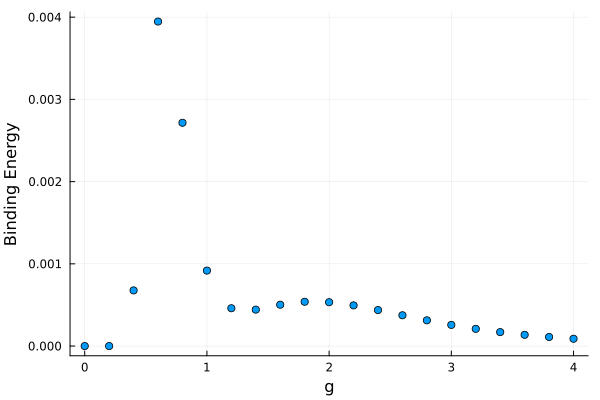

In [19]:
plot(0:0.2:4,BE,seriestype = :scatter, xlabel = "g", ylabel = "Binding Energy",legend=false)

## Calculating of the linear entropy between quarks and anti-quarks of the $\lvert \pi^+\rangle$, $S_L$ defined as:
## $S_L = 1 - {\rm Tr} [\rho_q^2] \ \ , \ \ \rho_q = {\rm Tr}_{\overline{q}} \left [\lvert \pi^+ \rangle \langle \pi^+ \rvert \right ]$

### The reduced density matrix $\rho_q$ obtained by tracing out the antiquarks. Takes in a state (usually an eigenvector of Hamiltonian), the corresponding basis and $N=2L$. Returns a dictionary (ket, bra) => coeff representing the reduced density matrix.

In [34]:
function buildRedDensMat(state,basis,N)
    # Map from basis vector (e.g. e_1) to bitstring
    reversedBasis = Dict{UInt32,UInt64}()
    # Maps a qbar state to all corresponding q state (bitstring, coeff)
    tempState = Dict{String,Array{Tuple{String,Float64}}}()
    # Reduced density matrix of the q state (ket, bra) => coeff
    redDensMat = Dict{Tuple{String,String},Float64}()
    for (key, value) in basis
        reversedBasis[value]= key
    end
    # Iterating through an eigenvector
    for i in 1:length(state)
        if abs(state[i]) > 1e-10
            # Get bitstring corresponding to i
            mystate = bitstring(reversedBasis[i])[64-6*N+1:64]
            # Just the quark state
            q = ""
            # Just the anti-quark state
            qbar = ""
            for site in 0:UInt8((N/2-1))
                q = q * mystate[1+site*12:6+site*12]
                qbar = qbar * mystate[7+site*12:12+site*12]
            end
            # Create the map qbar state => [(quark state, coeff),...]
            if haskey(tempState, qbar)
                tempState[qbar] = push!(tempState[qbar], (q, state[i]))
            else
                tempState[qbar] = [(q, state[i])]
            end
        end
    end
    # Iterate through map qbar state => [(quark state, coeff),...]
    for states in values(tempState)
        # Multiply bra times ket to get the element of the reduced density matrix
        for i in 1:length(states)
            for j in 1:length(states)
                elem = (states[i][1],states[j][1])
                if haskey(redDensMat, elem)
                    redDensMat[elem] = redDensMat[elem] + (states[i][2] * states[j][2])
                else
                    redDensMat[elem] = states[i][2] * states[j][2]
                end
            end
        end
    end
    redDensMat
end

buildRedDensMat (generic function with 1 method)

### The linear entropy

In [35]:
linent = []
B0ham = fullHamiltonian(1,buildSeed(0,4),4)
BBasis = buildBasis(1,buildSeed(0,4),4)
for i in 0:20
    BState = spectrum(1,i/5,0,B0ham)[2][:,1]
    tracesq = 0
    # For symmetric matrices the trace of the square is the sum of the squares of each matrix element
    for value in values(buildRedDensMat(BState,BBasis,4))
        tracesq = tracesq + value^2
    end
    push!(linent,1-tracesq)
end

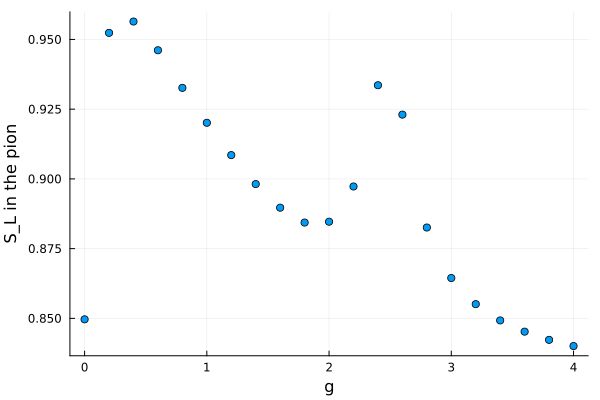

In [36]:
plot(0:0.2:4,linent,seriestype = :scatter, xlabel = "g", ylabel = "S_L in the pion",legend=false)

## Exact time evolution of the vacuum, from matrix exponentiation

In [39]:
m=1;g=1;
fh = fullHamiltonian(0,buildSeed(0,4),4)
spec = spectrum(m,g,0,fh)
vac = spec[2][:,1];

In [40]:
hamm = m*fh[1] + fh[2] + g^2 * fh[3]
persistenceProb = []
for t in 0:20
    out = expmv(-1im * t/5, hamm, vac) 
    # Expect 1 since time evolving an eigenstate
    push!(persistenceProb,abs(dot(vac, out))^2) 
end

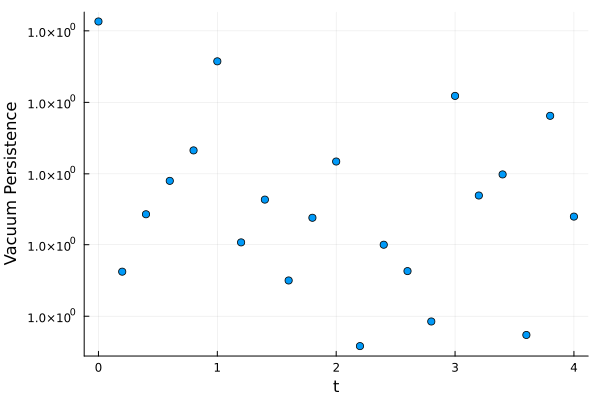

GKS: Possible loss of precision in routine SET_WINDOW


In [41]:
plot(0:0.2:4,persistenceProb,seriestype = :scatter, xlabel = "t", ylabel = "Vacuum Persistence",legend=false)

## Determining the basis of color singlets (supports parallelization). Color singlets are the null space of the operator:
## $ H_{\bf 1} = \frac{h^2}{2}
    \sum_{a=1}^{8}
    \left ( \sum_{m \leq L-1} Q^{(a)}_m \right ) ^2  $
## The null space is efficiently found through QR facorization.

In [21]:
# Sum of the squares of the gauge charges
hg = fullHamiltonian(-3/2,buildSeed(1,4),4)[4]

# QR decomposition
qrd = qr(hg)
factors = qrd.factors
τ       = qrd.τ
Nτ = length(τ)

qmat = Folds.mapreduce(i -> (I - factors[:,i]*τ[i]*factors[:,i]'), *, 1:Nτ, ThreadedEx())
rmat = qrd.R
rpiv = qrd.rpivinv

nsdim = 0
for i in -length(rpiv):-1
    if rmat[-i,-i] == 0.0
        nsdim+=1
    else
        break
    end
end
# Only keep the last columns
cs = qmat[:,length(rpiv)-nsdim+1:length(rpiv)]
# Permute the rows
cs = cs[rpiv,:]

27840×2320 SparseMatrixCSC{Float64, Int64} with 150624 stored entries:
⣾⣷⣧⡿
⣿⣿⡷⣿
⣿⣿⣷⡟
⣿⣿⣷⣧
⣿⣿⣿⣿
⣿⣿⣿⣿
⣿⣿⣿⡿
⣿⣿⣿⣧
⣿⣿⣿⣿
⣿⣿⣿⣿
⣿⣿⣿⠇
⣿⣿⣿⣿
⣿⣿⣿⣿
⣿⣿⣿⡟
⣿⣿⣿⣷
⣿⣿⣿⠏
⣿⣿⣿⣶
⣿⣿⣿⡿
⣿⣿⣿⣿
⣿⣿⣿⣿
⣿⣿⣿⣏
⣿⣿⣿⣟
⣿⣿⣿⡞
⣿⣿⣿⣷
⣿⣿⣿⣷
⣿⣿⣿⠷